In [30]:
#Initialising Hyper Parameters

#Uncomment one of the two below lines. For some reason, on some computers the first one works, while on others the second.
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import adam
import tensorflow as tf

import numpy as np
import keras

np.random.seed(10)  #for consistency of random numbers and our images

noise_dim = 100  # input dimension of random vector - the vector that goes into the generator

batch_size = 16   #How many images do we want to include in each batch
steps_per_epoch = 3750  #How many steps do we want to take per iteration of our training set (number of batches)
epochs = 200      #How many iterations of our training set do we want to do.

#change the below values to the dimensions of your image. The channels number refers to the number of colors
img_rows, img_cols, channels = 128, 128, 1

#These are the recommended values for the optimizer
optimizer = Adam(0.0002, 0.5)

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape

def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))  #The output layer has the same number of neurons as pixels in the image, because each neuron produces the color value for each pixel
    generator.add(Reshape((img_rows, img_cols,channels)))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer) # A standard cross entropy loss would work, because the feedback it is getting is whether it fooled the discriminator or not.
    
    return generator

In [45]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)
noise.shape,fake_x.shape

((16, 100), (16, 16384))

In [43]:
a=create_generator()

In [44]:
a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_27 (Dense)            (None, 16384)            

In [48]:
def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))  #sigmoid activation as output is 0/1 fake/real
    
    discriminator.compile(loss='binary_crossentropy', optimizer = optimizer)  #Binary Cross entropy loss as the discriminator has to try and classify all images (real or fake) in the right category
    
    return discriminator

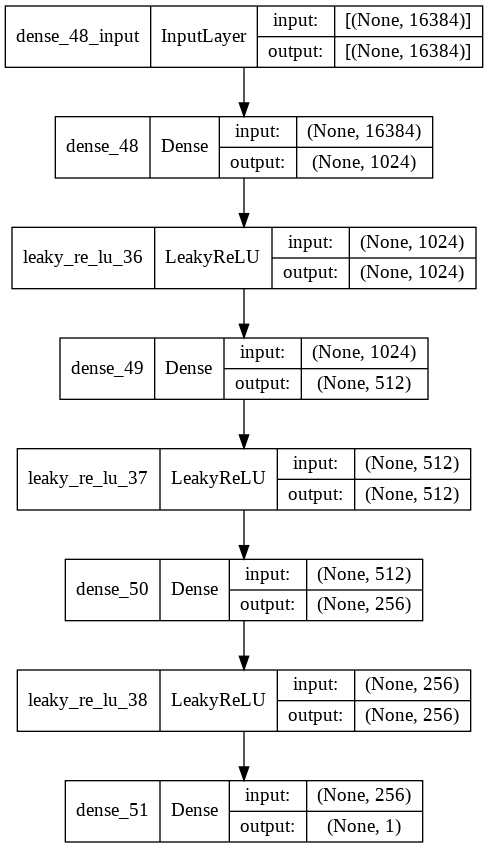

In [53]:
model=create_discriminator()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
b=create_discriminator()

In [50]:
b.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 1024)              16778240  
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_45 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 1)               

In [51]:
gan_input = Input(shape=(noise_dim,))    #We set the input of the whole model as the noise vector that the generator takes in as input. This is because the generator first has to develop an image for training to start.
fake_image = generator(gan_input)   

In [52]:
gan_output = discriminator(fake_image)

ValueError: ignored

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
x=np.load('/content/drive/MyDrive/brain tumor segmentation/GANS/asad data/non zeros masks/non zeros masks.npy')

In [9]:
x_train=x

In [11]:
x_train = np.expand_dims(x_train, axis = 3)

In [47]:
#combining the generator and discriminator to make a single large gan (loss and derivatives have to flow from discriminator to generator)

from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()   #Creating the discriminator using the function
generator = create_generator()           #Creating the generator using the function

discriminator.trainable = False          #We will set this to false, so that when we train the entire GAN together, only the generator part will be trained. We will train the discriminator separately. See below code block for more details.

gan_input = Input(shape=(noise_dim,))    #We set the input of the whole model as the noise vector that the generator takes in as input. This is because the generator first has to develop an image for training to start.
fake_image = generator(gan_input)        #Image generated by GAN for this noise vector is stored in fake_image

gan_output = discriminator(fake_image)   #The output of the GAN is the discriminator

gan = Model(gan_input, gan_output)       #Finally putting the generator and discriminator together
gan.compile(loss='binary_crossentropy', optimizer=optimizer)  # Using binary cross entropy loss (same as discriminator loss)

ValueError: ignored

In [19]:
#Code for plotting results
import matplotlib.pyplot as plt

def show_images(noise, size_fig):
    generated_images = generator.predict(noise)   #Create the images from the GAN.
    plt.figure(figsize=size_fig)
    
    for i, image in enumerate(generated_images):
        plt.subplot(size_fig[0], size_fig[1], i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')    #If the image is grayscale, as in our case, then we will reshape the output in the following way.
                                                                            #Also, we set the coloring to grayscale so that it doesn't look like it came out of an infrared camera :)
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()   #Tight layout so that all of the generated images form a nice grid
    plt.show()

In [20]:
for epoch in range(epochs):         #iterate the dataset for the number of epochs
    for batch in range(steps_per_epoch):    #for the number of batches we wanted to create
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))   #We generate a new noise vector to feed the generator before every training iteration
        fake_x = generator.predict(noise)        #The image the generator develops for the noise vector we created above

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]  #We won't use all real images from our dataset at once, we will only select a random sample of images
        
        x = np.concatenate((real_x, fake_x))    #making the x dataset for the discriminator. This includes a mix of real and fake examples for the discriminator to correctly classify

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)   #We are training the discriminator separately. Remember, we set trainable = false when adding it to the GAN, so that when we train the GAN, we only train the generator. Hence this extra step

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)       #Now we train the entire GAN. But since the discriminator can't be trained, only the generator is trained in this step.

    print(f'Epoch: {epoch + 1} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    noise = np.random.normal(0, 1, size=(25, noise_dim))
    show_images(noise, (5, 5))

ValueError: ignored

In [13]:
real_x.shape

(16, 128, 128, 1)

In [21]:
fake_x.shape

(16, 16384)

In [24]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)

(16, 100)

In [26]:
fake_x = generator.predict(noise)
fake_x.shape

(16, 16384)